# PREPROCESSING

### IMPORT




In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing


tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#UNZIP THE ALREADY CREATED FOLDER
!unzip "/content/data_splitted_final.zip" -d "/content"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data_splitted_final/train/Species6/00146.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00146.jpg  
  inflating: /content/data_splitted_final/train/Species6/00152.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00152.jpg  
  inflating: /content/data_splitted_final/train/Species6/00185.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00185.jpg  
  inflating: /content/data_splitted_final/train/Species6/00191.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00191.jpg  
  inflating: /content/data_splitted_final/train/Species6/00032.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00032.jpg  
  inflating: /content/data_splitted_final/train/Species6/00027.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00027.jpg  
  inflating: /content/data_splitted_final/train/Species6

In [ ]:
os.chdir("/content/data_splitted_final")

In [ ]:
#CHECK PRESENCE OF THE TWO FOLDERS
!ls

train  val


In [ ]:
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

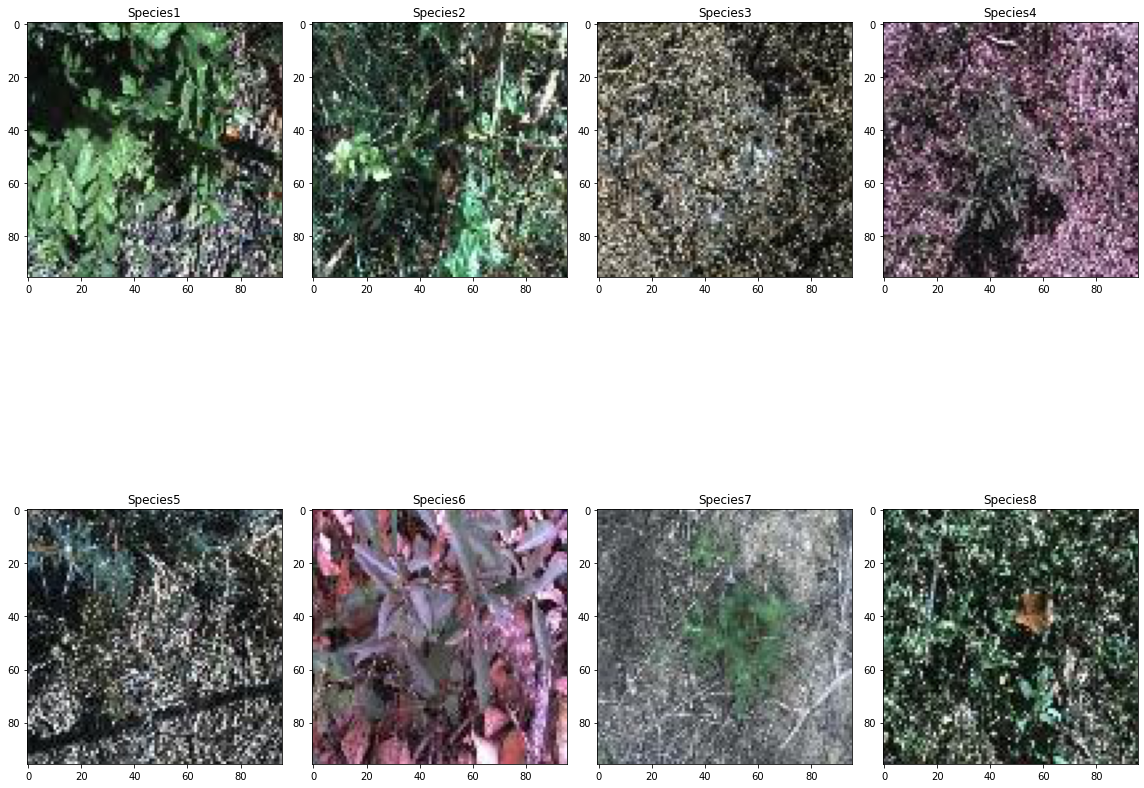

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#PATH TO GET TRAIN AND VAL FOLDERS
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#DID SOME AUGMENTATION: ROTATION,BRIGHTENSS, SHEAR, FLIP, SHIFTS, NO NEED TO DO ANY PREPROCESSING
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=35,
                                        height_shift_range=0.25,
                                        width_shift_range=0.25,
                                        zoom_range=0.25,
                                        brightness_range = (0.75,1.25),
                                        shear_range = 0.15,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        ) 

valid_data_gen = ImageDataGenerator()


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (260,260),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (260,260),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
#B2 REQUIRES 260,260 IMAGES AS INPUT
input_shape = (260, 260, 3)
epochs = 45

### CNN MODEL

In [ ]:
#DOWNLOADING B2 WITH WEIGHTS TRAINED ON IMAGENET AND MAKE ALL LAYERS NOT TRAINABLE
efficient_netb2 = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape= input_shape)
for layer in efficient_netb2.layers:
  layer.trainable = False
efficient_netb2.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TF

In [ ]:
#OUR MODEL: IMPUT + EFFICIENTNETB2 + GLOBALPOOLING + DROPOUT (VERY HIGH RATE) + OUTPUT LAYER
inputs = tfk.Input(shape= (260,260,3))

x1 = efficient_netb2(inputs)

x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    
x = tfkl.Dropout(0.55, name="dropout1")(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax'
    )(x)


efficientb2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')



In [ ]:
# Compile the model. FIRST LR IS VERY LOW
efficientb2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')
efficientb2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.01), metrics='accuracy')
efficientb2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1408)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
Total params: 7,779,841
Trainable params: 11,272
Non-trainable params: 7,768,569
______________________________________________

to balance the class weights


In [ ]:
#TO GIVE MORE IMPORTANCE TO THE SAMPLES FROM LESS REPRESENTED CLASSES
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
efficientb2.get_layer('efficientnetb2').trainable = False
for i, layer in enumerate(efficientb2.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)

efficientb2.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
# Train the model
history = efficientb2.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/45
177/177 [==============================] - 94s 420ms/step - loss: 4.1198 - accuracy: 0.4507 - val_loss: 1.6499 - val_accuracy: 0.4937
Epoch 2/45
177/177 [==============================] - 56s 318ms/step - loss: 3.8806 - accuracy: 0.5104 - val_loss: 1.3808 - val_accuracy: 0.5231
Epoch 3/45
177/177 [==============================] - 54s 306ms/step - loss: 4.2931 - accuracy: 0.5062 - val_loss: 1.5011 - val_accuracy: 0.4951
Epoch 4/45
177/177 [==============================] - 53s 301ms/step - loss: 4.2580 - accuracy: 0.5313 - val_loss: 1.9275 - val_accuracy: 0.4334
Epoch 5/45
177/177 [==============================] - 53s 302ms/step - loss: 4.1072 - accuracy: 0.5387 - val_loss: 1.3343 - val_accuracy: 0.5442
Epoch 6/45
177/177 [==============================] - 54s 304ms/step - loss: 4.2822 - accuracy: 0.5429 - val_loss: 1.5187 - val_accuracy: 0.5147
Epoch 7/45
177/177 [==============================] - 53s 298ms/step - loss: 4.5141 - accuracy: 0.5235 - val_loss: 1.7964 - val_ac

### Plot the training

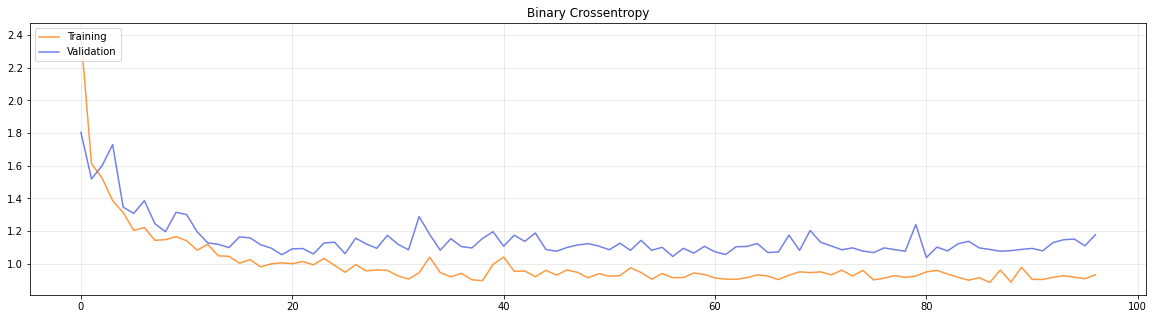

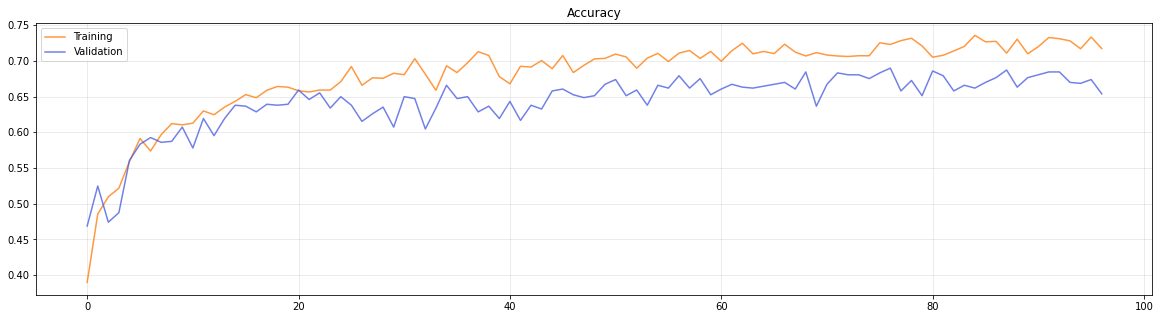

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
efficientb2.save('/content/drive/MyDrive/FINAL/B2_TL')

In [ ]:
%cd /content/drive/MyDrive/FINAL

/content/drive/MyDrive/FINAL


### Fine Tuning

In [ ]:
#LOAD THE SAVED MODEL
ft_model = tfk.models.load_model('B2_TL')

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1408)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
Total params: 7,779,841
Trainable params: 11,272
Non-trainable params: 7,768,569
______________________________________________

In [ ]:
# Set all B2 layers to TRAINABLE
ft_model.get_layer('efficientnetb2').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

In [ ]:
#FREEZE ONLY FIRST 40 LAYERS
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers[:40]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
#LOW LEARNING RATE
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')


In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 50,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/50
177/177 [==============================] - 80s 371ms/step - loss: 6.9827 - accuracy: 0.4019 - val_loss: 1.5490 - val_accuracy: 0.5035
Epoch 2/50
177/177 [==============================] - 64s 359ms/step - loss: 4.3292 - accuracy: 0.5313 - val_loss: 1.3744 - val_accuracy: 0.5806
Epoch 3/50
177/177 [==============================] - 65s 366ms/step - loss: 3.3048 - accuracy: 0.5924 - val_loss: 1.1685 - val_accuracy: 0.6297
Epoch 4/50
177/177 [==============================] - 64s 360ms/step - loss: 2.9317 - accuracy: 0.6260 - val_loss: 1.0895 - val_accuracy: 0.6396
Epoch 5/50
177/177 [==============================] - 64s 360ms/step - loss: 2.4555 - accuracy: 0.6783 - val_loss: 0.9948 - val_accuracy: 0.6774
Epoch 6/50
177/177 [==============================] - 65s 366ms/step - loss: 2.2509 - accuracy: 0.7055 - val_loss: 0.8920 - val_accuracy: 0.7209
Epoch 7/50
177/177 [==============================] - 64s 361ms/step - loss: 2.1010 - accuracy: 0.7225 - val_loss: 0.8442 - val_ac

In [ ]:
ft_model.save('/content/drive/MyDrive/A2NDL/efficientb2_89acc')

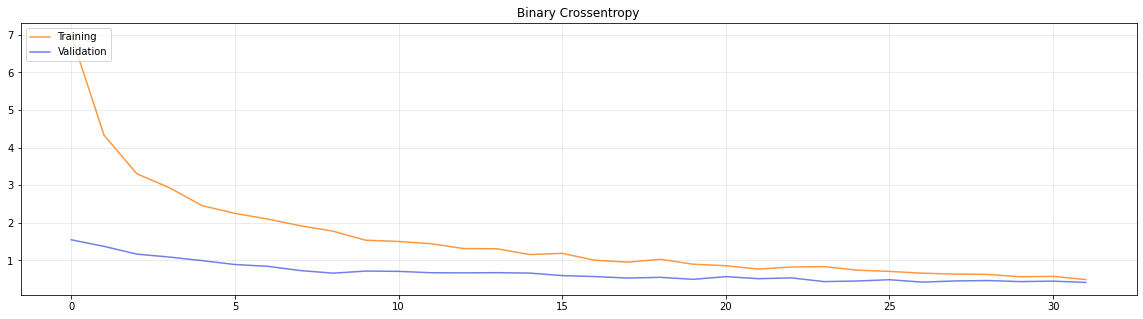

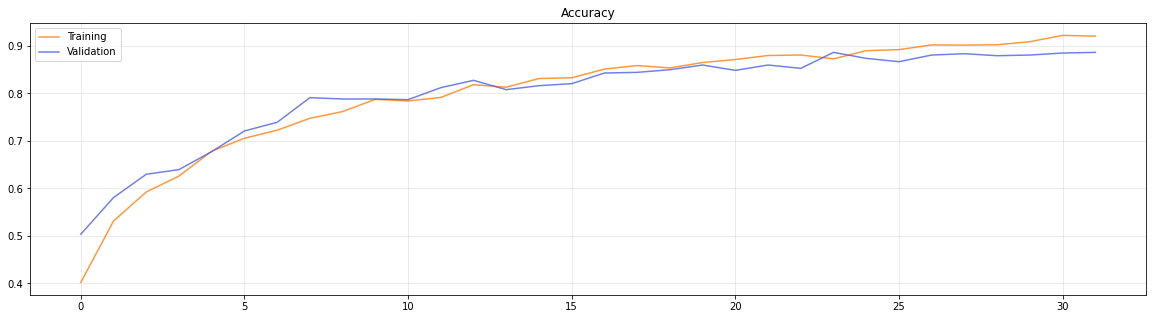

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()